In [ ]:
! pip install transformers

In [1]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 17), reused 39 (delta 10), pack-reused 0
Unpacking objects: 100% (50/50), 27.83 MiB | 4.41 MiB/s, done.


In [2]:
import sys

sys.path.append('space-model')

In [3]:
import math
import json
from collections import Counter
import random
import os

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

from datasets import load_dataset, Dataset, DatasetDict

from space_model.model import *
from space_model.loss import *

In [4]:
device_id = 0

In [5]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
torch.cuda.set_device(device)

In [7]:
train_df = pd.read_csv('data/news.csv', index_col=0)
train_df

,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [9]:
original_df = pd.read_csv('data/train.csv', index_col=0)
original_df = original_df[original_df['title'].notnull() & original_df['text'].notnull()]
original_df

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0


In [10]:
train_df = train_df[train_df['title'].notnull() & train_df['text'].notnull()]
train_df

,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [12]:
# see the intersection of the two datasets based on title
len(set(train_df['title'].tolist()).intersection(set(original_df['title'].tolist())))

2515

In [13]:
train_df = train_df[~train_df['title'].isin(original_df['title'].tolist())]
train_df

,title,text,label
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
...,...,...,...
6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,FAKE
3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,REAL
4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [14]:
train_df['final'] = 'Title: ' + train_df['title'] + ' Text: ' + train_df['text']

/var/tmp/ipykernel_1599325/993384156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['final'] = 'Title: ' + train_df['title'] + ' Text: ' + train_df['text']


In [15]:
def encode_label(s: str):
    if s == 'FAKE':
        return 1
    else:
        return 0

In [16]:
train_df['label'] = train_df['label'].apply(encode_label)
train_df

/var/tmp/ipykernel_1599325/4068649279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'] = train_df['label'].apply(encode_label)


,title,text,label,final
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,Title: Kerry to go to Paris in gesture of symp...
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,Title: The Battle of New York: Why This Primar...
7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",1,Title: Girl Horrified At What She Watches Boyf...
95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,0,Title: ‘Britain’s Schindler’ Dies at 106 Text:...
4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,0,Title: Fact check: Trump and Clinton at the 'c...
...,...,...,...,...
6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,1,Title: DOJ COMPLAINT: Comey Under Fire Over Pa...
3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,0,Title: GOP Senator David Perdue Jokes About Pr...
4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,0,Title: State Department says it can't find ema...
4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",0,"Title: In Ethiopia, Obama seeks progress on pe..."


<Axes: >

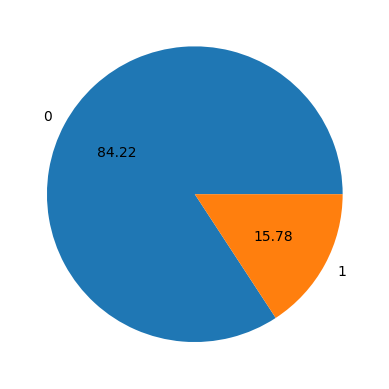

In [17]:
train_df.groupby('label').size().plot(kind='pie', autopct='%.2f')

In [45]:
MODEL_NAME = 'bert-base-cased'
MODELS_PATH = 'models'
DATASET_NAME = 'fake-news'

# SEED = 
NUM_EPOCHS = 50
BATCH_SIZE = 256
MAX_SEQ_LEN = 512
N_LATENT = 64

In [19]:
val_dataset = DatasetDict({
    'test': Dataset.from_pandas(train_df[['final', 'label']]),
})
val_dataset

DatasetDict({
    test: Dataset({
        features: ['final', 'label', '__index_level_0__'],
        num_rows: 3764
    })
})

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [21]:
val_dataset = val_dataset.map(lambda x: tokenizer(x['final'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
val_dataset.set_format('torch', device=device)
val_dataset

Map:   0%|          | 0/3764 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['final', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3764
    })
})

## Base Model

In [22]:
state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin')

In [23]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, state_dict=state_dict).to(device)
base_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [24]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

In [25]:
def concept_space_to_preds(concept_spaces):
    tensor_concept_spaces = torch.cat([cs.unsqueeze(0) for cs in concept_spaces], dim=0)
    concept_space_dist = tensor_concept_spaces.permute(1, 0, 2, 3).mean(dim=(2, 3)) # (B, n)
    return torch.argmax(concept_space_dist, dim=1).detach().cpu().tolist()

In [26]:
@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    cs_val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            ### Distance Based Classification
            # out.concept_spaces (n, B, seq_len, n_latent)
            if hasattr(outputs, 'concept_spaces'):
                cs_val_preds += concept_space_to_preds(outputs.concept_spaces)
            ### END

            val_loss += loss.item()
    return val_loss, val_preds, val_labels, cs_val_preds

In [27]:
val_dataloader = torch.utils.data.DataLoader(val_dataset['test'], batch_size=2 * BATCH_SIZE)

In [29]:
val_loss, val_preds, val_labels, _ = eval_epoch(base_model, val_dataloader)

100%|██████████| 8/8 [00:24<00:00,  3.09s/it]


In [32]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='macro')
val_recall = recall_score(val_labels, val_preds, average='macro')

In [33]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.6034892424941063
Val acc: 0.7736450584484591
Val f1: 0.60438831657343
Val precision: 0.5985252684355311
Val recall: 0.6132109740942548


## Space Model

In [46]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [47]:
space_model = SpaceModelForSequenceClassification(base_model, n_embed=768, n_latent=N_LATENT, n_concept_spaces=2, l1=0, l2=0).to(device)
space_model.load_state_dict(torch.load(f'{MODELS_PATH}/{DATASET_NAME}_space-{MODEL_NAME}_{N_LATENT}_{NUM_EPOCHS}.bin'))
space_model

SpaceModelForSequenceClassification(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [48]:
val_loss, val_preds, val_labels, cs_val_preds = eval_epoch(space_model, val_dataloader)

100%|██████████| 8/8 [00:24<00:00,  3.10s/it]


In [49]:
cs_val_acc = accuracy_score(val_labels, cs_val_preds)
cs_val_f1 = f1_score(val_labels, cs_val_preds, average='macro')

val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds, average='macro')
val_recall = recall_score(val_labels, val_preds, average='macro')

In [50]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'CS Val acc: {cs_val_acc}')
print(f'Val f1: {val_f1}')
print(f'CS Val f1: {cs_val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.4666294679045677
Val acc: 0.7996811902231669
CS Val acc: 0.8071200850159405
Val f1: 0.7068660571639159
CS Val f1: 0.615265787868668
Val precision: 0.6846910506185717
Val recall: 0.7798372792063644
